This file is part of Estimation of Causal Effects in the Alzheimer's Continuum (Causal-AD).

Causal-AD is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

Causal-AD is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with Causal-AD. If not, see <https://www.gnu.org/licenses/>.

# Step 2: Estimate Effects

In [1]:
suppressMessages(library(bayesplot))
suppressMessages(library(rstanarm))
suppressMessages(library(rstan))
suppressMessages(library(dplyr))

options(mc.cores = 4)

Warning message:
“package ‘bayesplot’ was built under R version 3.6.3”
Warning message:
“package ‘rstanarm’ was built under R version 3.6.3”
Warning message:
“package ‘rstan’ was built under R version 3.6.3”
Warning message:
“package ‘StanHeaders’ was built under R version 3.6.3”
Warning message:
“package ‘ggplot2’ was built under R version 3.6.3”
Warning message:
“package ‘dplyr’ was built under R version 3.6.3”


In [2]:
do.std <- function(data) {
    std.cols <- c("AGE", "ABETA", "PTAU")
    out <- data
    for (col in std.cols) {
        out[,col] <- (data[,col] - mean(data[,col])) / sd(data[,col])
    }
    for (col in grep("^Deconf_", colnames(data))) {
        out[,col] <- (data[,col] - mean(data[,col])) / sd(data[,col])
    }
    return(out)
}

read.orig.volumes <- function(vol.names) {    
    adni <- read.csv("data/adni-transformed.csv", row.names=1)
    vols <- adni[, vol.names]
    return(vols)
}

read.aug.csv <- function(filename, use.residuals=TRUE) {
    cat.cols <- c("PTGENDER")

    aug_ppca <- read.csv(filename, row.names=1)

    aug_ppca <- dplyr::select(aug_ppca, -SITE, -IMAGEUID, -COLPROT)
    aug_ppca$ATN_status <- relevel(aug_ppca$ATN_status, 'A+/T-/N-')
    aug_ppca$ApoeSubtype <- relevel(aug_ppca$ApoeSubtype, 'Apo-e3e3')
    aug_ppca$PTGENDER <- relevel(aug_ppca$PTGENDER, 'Female')
    aug_ppca$EDU.ATTAIN <- relevel(aug_ppca$EDU.ATTAIN, 'less_or_equal_12')

    for (col in cat.cols) {
        aug_ppca[,col] <- as.factor(aug_ppca[,col])
    }

    # Convert ADAS13 to proportions.
    max.ADAS13 <- 85
    if(any(aug_ppca$ADAS13 >= max.ADAS13)) error("ADAS13 score too big")
    if(any(aug_ppca$ADAS13 <= 0)) error("ADAS13 score too small")
    aug_ppca$ADAS13 <- aug_ppca$ADAS13 / 85

    # Standardize AGE and PTEDUCAT.
    # MRI features are already standardized when computing substitute confounder.
    aug_ppca <- do.std(aug_ppca)

    included <- grep("\\.resid$", colnames(aug_ppca))
    if (use.residuals) {
        vols <- aug_ppca[, included]
    } else {
        vol.names <- sub("\\.resid$", "", colnames(aug_ppca)[included])

        orig.vols <- read.orig.volumes(vol.names)
        orig.vols <- orig.vols[rownames(aug_ppca),]
        aug.cols <- grep("^Deconf_", colnames(aug_ppca))
        vols <- cbind(orig.vols, aug_ppca[, aug.cols], aug_ppca[, "AGE", drop=FALSE])
    }

    output <- cbind(vols, aug_ppca[, "ADAS13", drop=FALSE])
#     print(toString(colnames(output)))
    return(output)
}

In [3]:
aug_dir <- "data/outputs/adni/dim6/"

aug_ppca <- read.aug.csv(paste0(aug_dir, "adni_aug_PPCA.csv"), use.residuals=TRUE)
aug_bpmf <- read.aug.csv(paste0(aug_dir, "adni_aug_BPMF.csv"), use.residuals=TRUE)
aug_regout <- read.aug.csv(paste0(aug_dir, "adni_aug_regressout.csv"))
data_noconf <- read.orig.volumes(sub("\\.resid$", "", colnames(aug_regout)))
data_noconf$ADAS13 <- data_noconf$ADAS13 / 85

## Split into train and test

In [4]:
apply.split <- function(idx.train, idx.test, data) {
    y.idx <- which(colnames(data) == "ADAS13")
    train.d <- data[idx.train,]
    m <- colMeans(train.d)
    s <- apply(train.d, 2, sd)
    if (any(s < 1e-9)) error("very low stdev detected!")
    m[y.idx] <- 0
    s[y.idx] <- 1

    test.d <- data[idx.test,]
    return(list(train=train.d, test=test.d))
}

set.seed(2501)
idx <- sample(1:nrow(data_noconf))
num_test <- as.integer(0.1 * nrow(data_noconf))
test_idx <- rownames(data_noconf)[idx[1:num_test]]
train_idx <- rownames(data_noconf)[idx[(num_test + 1):nrow(data_noconf)]]

ds <- apply.split(train_idx, test_idx, data_noconf)
train_noconf <- ds$train
test_noconf <- ds$test
rm(ds)

ds <- apply.split(train_idx, test_idx, aug_regout)
train_regout <- ds$train
test_regout <- ds$test
rm(ds)

ds <- apply.split(train_idx, test_idx, aug_ppca)
train_ppca <- ds$train
test_ppca <- ds$test
rm(ds)

ds <- apply.split(train_idx, test_idx, aug_bpmf)
train_bpmf <- ds$train
test_bpmf <- ds$test

print(c(nrow(data_noconf), nrow(train_noconf), nrow(test_noconf)))

[1] 711 640  71


## Fit Models

In [5]:
fit_betareg <- function(data) {
    mm <- terms(as.formula(ADAS13 ~ .), data=data)
    frm <- paste("ADAS13 ~", paste(attr(mm, "term.labels"), collapse = "+"))
    cat(frm)
    f <- as.formula(frm)
    f <- stan_betareg(f,
                      data = data,
                      link = "logit",
                      link.phi = "identity",
                      prior = normal(location = 0, scale = 3),
                      prior_intercept = normal(location = 0, scale = 10),
                      prior_phi = cauchy(0, 5),
                      iter = 5000,
                      seed = 2501,
                      na.action=na.fail)
    return(f)
}

In [6]:
fit_noconf <- fit_betareg(train_noconf)

ADAS13 ~ Brain.Stem+CSF+Optic.Chiasm+Cerebellum.White.Matter+Cerebellum.Cortex+Thalamus.Proper+Caudate+Putamen+Pallidum+Hippocampus+Accumbens.area+vessel+CC+Ventricle+parahippocampal_thickness+caudalanteriorcingulate_thickness+fusiform_thickness+lateralorbitofrontal_thickness+insula_thickness+entorhinal_thickness+precuneus_thickness+rostralmiddlefrontal_thickness

In [7]:
fit_regout <- fit_betareg(train_regout)

ADAS13 ~ Brain.Stem.resid+CSF.resid+Optic.Chiasm.resid+Cerebellum.White.Matter.resid+Cerebellum.Cortex.resid+Thalamus.Proper.resid+Caudate.resid+Putamen.resid+Pallidum.resid+Hippocampus.resid+Accumbens.area.resid+vessel.resid+CC.resid+Ventricle.resid+parahippocampal_thickness.resid+caudalanteriorcingulate_thickness.resid+fusiform_thickness.resid+lateralorbitofrontal_thickness.resid+insula_thickness.resid+entorhinal_thickness.resid+precuneus_thickness.resid+rostralmiddlefrontal_thickness.resid

In [8]:
fit_ppca <- fit_betareg(train_ppca)

ADAS13 ~ Brain.Stem.resid+CSF.resid+Optic.Chiasm.resid+Cerebellum.White.Matter.resid+Cerebellum.Cortex.resid+Thalamus.Proper.resid+Caudate.resid+Putamen.resid+Pallidum.resid+Hippocampus.resid+Accumbens.area.resid+vessel.resid+CC.resid+Ventricle.resid+parahippocampal_thickness.resid+caudalanteriorcingulate_thickness.resid+fusiform_thickness.resid+lateralorbitofrontal_thickness.resid+insula_thickness.resid+entorhinal_thickness.resid+precuneus_thickness.resid+rostralmiddlefrontal_thickness.resid

In [9]:
fit_bpmf <- fit_betareg(train_bpmf)

ADAS13 ~ Brain.Stem.resid+CSF.resid+Optic.Chiasm.resid+Cerebellum.White.Matter.resid+Cerebellum.Cortex.resid+Thalamus.Proper.resid+Caudate.resid+Putamen.resid+Pallidum.resid+Hippocampus.resid+Accumbens.area.resid+vessel.resid+CC.resid+Ventricle.resid+parahippocampal_thickness.resid+caudalanteriorcingulate_thickness.resid+fusiform_thickness.resid+lateralorbitofrontal_thickness.resid+insula_thickness.resid+entorhinal_thickness.resid+precuneus_thickness.resid+rostralmiddlefrontal_thickness.resid

In [10]:
write.csv(fit_noconf$stan_summary, file=paste0(aug_dir, "coef_noconf.csv"))
write.csv(fit_regout$stan_summary, file=paste0(aug_dir, "coef_regout.csv"))
write.csv(fit_ppca$stan_summary, file=paste0(aug_dir, "coef_ppca.csv"))
write.csv(fit_bpmf$stan_summary, file=paste0(aug_dir, "coef_bpmf.csv"))

Continue with [Step 3: Compare Effects](adni-compare-effects.ipynb).

## Optional: Posterior Predictive Check

This may take a while.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



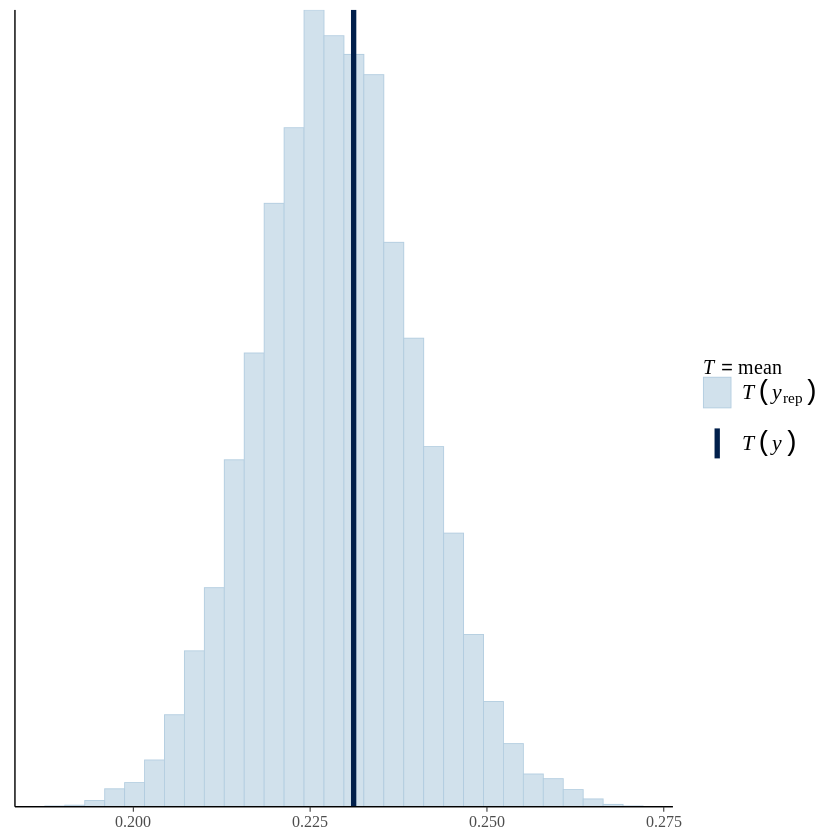

In [11]:
ppc_stat(test_noconf$ADAS13,
         posterior_predict(fit_noconf, newdata = test_noconf),
         stat="mean")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



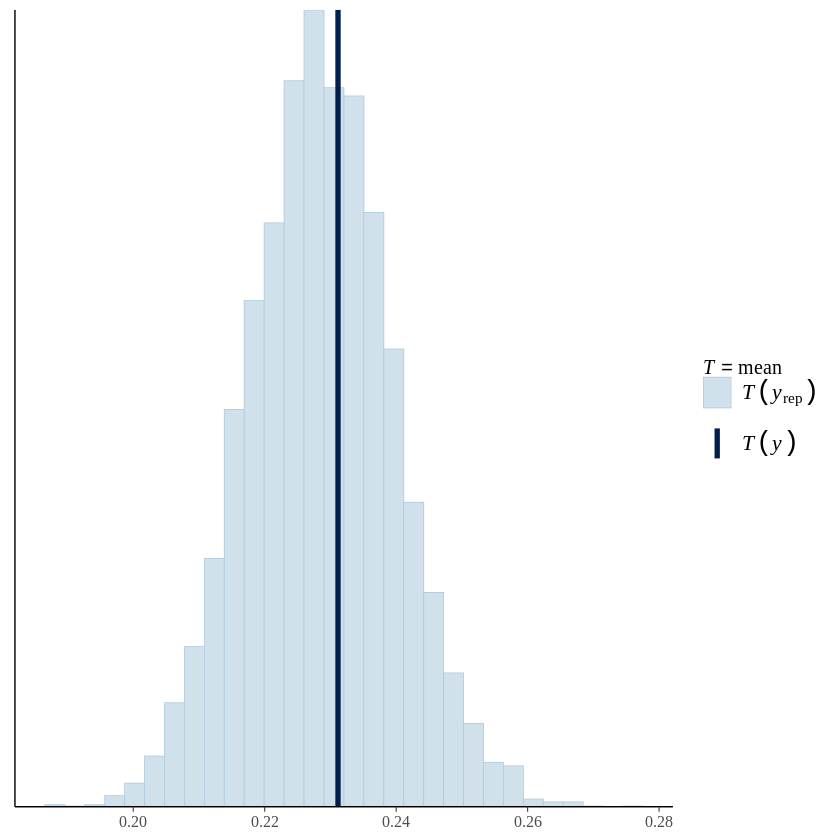

In [12]:
ppc_stat(test_regout$ADAS13,
         posterior_predict(fit_regout, newdata = test_regout),
         stat="mean")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



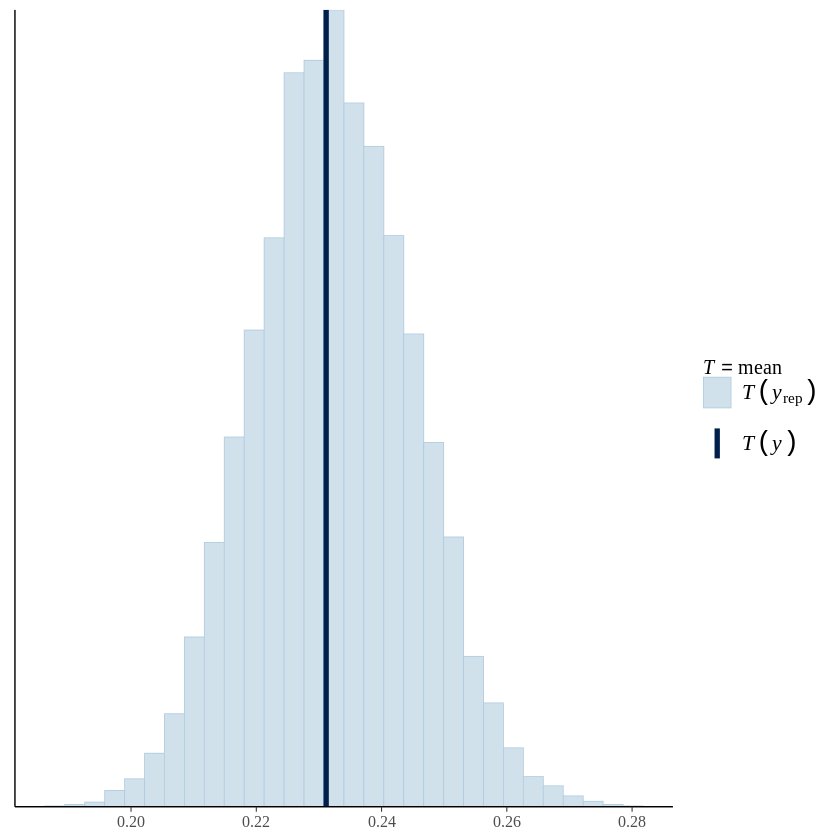

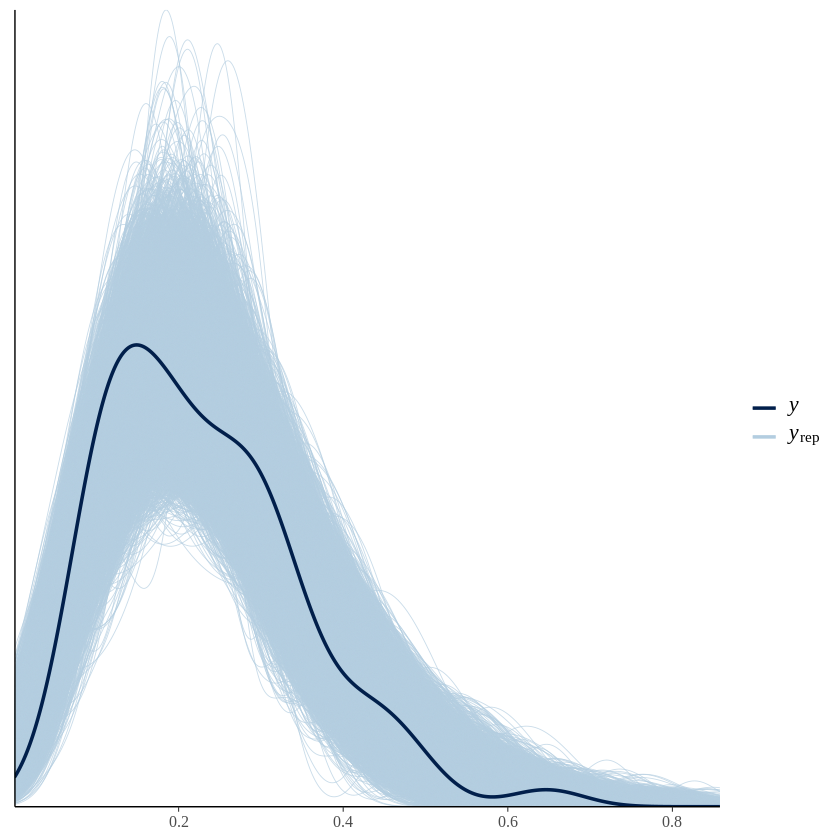

In [13]:
yrep <- posterior_predict(fit_ppca, newdata = test_ppca)
ppc_stat(test_ppca$ADAS13, yrep, stat="mean")
ppc_dens_overlay(test_ppca$ADAS13, yrep)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



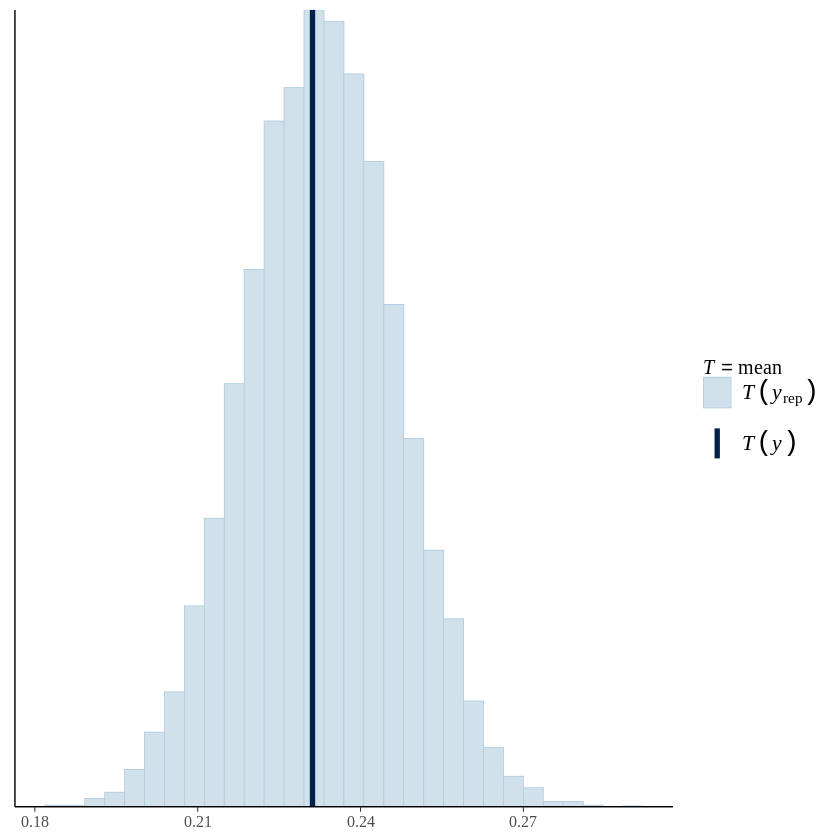

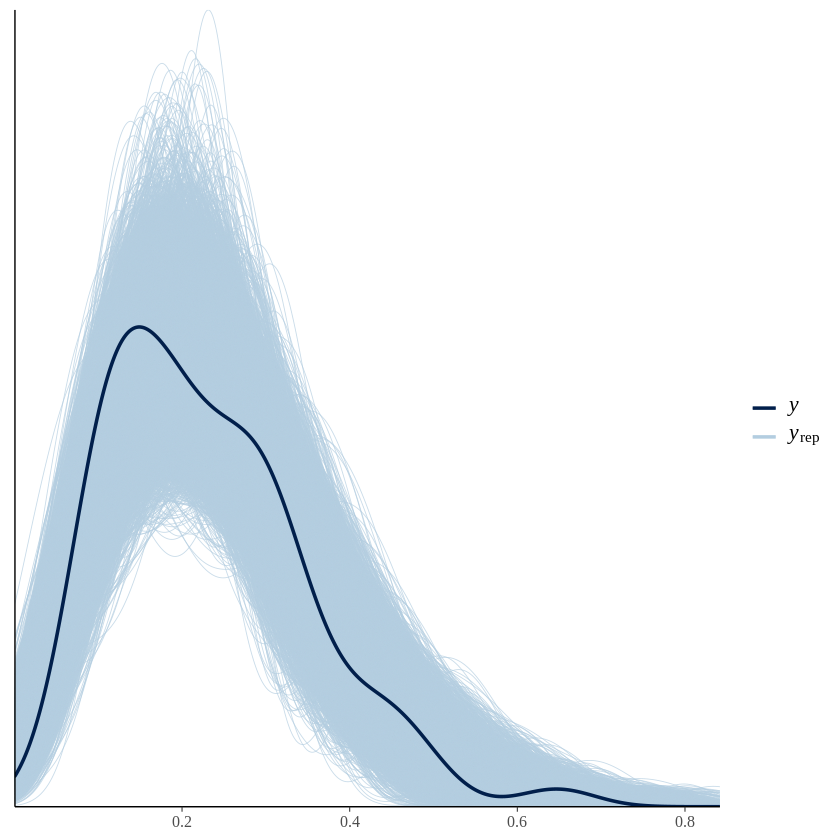

In [14]:
yrep <- posterior_predict(fit_bpmf, newdata = test_bpmf)
ppc_stat(test_bpmf$ADAS13, yrep, stat="mean")
ppc_dens_overlay(test_bpmf$ADAS13, yrep)